<a href="https://colab.research.google.com/github/saugabriele/MLSEC_project/blob/main/MLSEC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML_SEC Project** -- Sau Gabriele 70-90-00474
In this project, I need to craft universal adversarial examples that are capable of fooling three specific models from RobustBench (CIFAR10, L-inf) simultaneously. These adversarial examples should be designed to be untargeted, meaning they cause misclassification without a specific target label in mind.

After creating the universal adversarial examples, I will then evaluate their transferability to seven other models. By testing the universal adversarial examples on the additional seven models, I can assess how effective they are in bypassing a wider range of defenses and generalizing across different architectures.

# Importing RobustBench and Secml

In [ ]:
try:
  import robustbench
except ImportError:
  %pip install git+https://github.com/RobustBench/robustbench.git

In [ ]:
try:
    import secml
    import foolbox
except ImportError:
    %pip install git+https://github.com/pralab/secml
    %pip install foolbox

# Loading models from RobustBench
In this section, I am loading three distinct models from RobustBench that are specifically trained on the CIFAR10 dataset under the L-Inf threat model. The models selected are "**Carmon2019Unlabeled**", "**Pang2020Boosting**" and "**Gowal2020Uncovering_70_16**".
The three models loaded are variants of the Wide Residual Network architecture:
* **Carmon2019Unlabeled**: This model is a WideResNet-28-10.  In the specific case of the WideResNet-28-10, the number 28 indicates the number of convolution filters in each residual block, while the number 10 indicates the widening factor, which is used to increase the number of channels in each convolutional layer.
* **Pang2020Boosting**: This model is a WideResNet-34-20. It consists of 34 convolution filters in each residual block with a widening factor of 20. So the WideResNet-34-20 model is composed of 34 convolution filters in each residual block and an expansion factor of 10.
* **Gowal2020Uncovering_70_16**: This model is a WideResNet-70-16. It consists of 70 convolution filters in each residual block with a widening factor of 16. This WideResNet-106-16 is the deepest model and has a moderate widening factor compared to WideResNet-34-20 and WideResNet-28-10.

This model is obtained by the paper "Unlabeled Data Improves Adversarial
Robustness". With this paper the authors decide to demonstrate that adversarial
robustness can benefits from semi-supervised learning. They propose a
semisupervised learning procedure (self-training) to achieve state-of-art
robust accuracy in l-inf robustness against several attacks via adversarial
training adding to the CIFAR-10 dataset 500K unlabeled images. They exploits the
fact that the labeled data alone already produce accurate classifiers which are
used on the unlabeled and obtain useful pseudo-labels (self-training). Overall, the goal of these robust training techniques is to improve the model's robustness, stability, and generalization capability, ultimately leading to better performance.
<br>
The second model is obtained from the paper "Boosting Adversarial Training with Hypersphere Embedding" which involves leveraging hypersphere embedding to enhance adversarial training performance. The paper proposes leveraging hypersphere embedding in conjunction with adversarial training to boost the model's robustness against adversarial attacks. The goal of this mechanisms inducing a larger interclass variance and margin under the angular metric in feature space. By embedding in the mechanisms the use of angular margins these will lead the model to learns more structured and discriminative representations of the input data, which can help improve its robustness. This structured representation can aid in separating clean and adversarial examples more effectively, leading to better generalization and robustness.
<br>
The third model is obtained from the paper "Uncovering the Limits of Adversarial Training against Norm-Bounded Adversarial Examples". The paper focuses on increasing the robustness of the model. The stategies used are adversarial training where the model is trained using a combination of clean examples and unlabeled data generated through pseudo-labeling techniques such as in the previous model. Furthermore, a activation function called Swish/SiLU is used after each convolutional layer. This activation function helps the model learn richer and more complex data representations. Lastly, a technique called model weight averaging is employed, which involves calculating the average of the weights of models trained in different iterations.

In [ ]:
import shutil
import os
from os import path
from robustbench.utils import load_model
from google.colab import drive

# Check if the directory 'Linf' exists, if not, create it
if path.exists('/content/models/cifar10/Linf') == False:
  os.makedirs('/content/models/cifar10/Linf')

# Mount Google Drive to access files
drive.mount('/content/drive')

models = []
model_names = ['Carmon2019Unlabeled', 'Pang2020Boosting',
               'Gowal2020Uncovering_70_16']

# Load the models using the 'load_model' function after loading them from Google Drive
for name in model_names:
  shutil.copy("/content/drive/MyDrive/" + name + ".pt", "/content/models/cifar10/Linf")
  models.append(load_model(model_name=name, dataset='cifar10', threat_model='Linf'))

Mounted at /content/drive


#Preprocessing Stage
In this section, the CIFAR-10 dataset is loaded using the CDataLoaderCIFAR10 class from the SECML library. The dataset is split into training and testing sets. The CIFAR-10 dataset consists of images of 10 different classes, such as 'airplane', 'automobile', 'bird', etc. These class labels are stored in the dataset_labels list. Next, a normalizer is created using CNormalizerMinMax and fitted to the training data.<br>
For the project, ten images are selected from the test set which will be used to create the adversarial samples. For each image the normalization is applied, the results are stored in the images list and the corresponding labels in a second list.<br>
Finally, I create SecML classifiers using pre-trained PyTorch models previously loaded from RobustBench and then I used these classifiers to make predictions on the images contained in the list.

In [ ]:
from secml.data.loader.c_dataloader_cifar import CDataLoaderCIFAR10
train_ds, test_ds = CDataLoaderCIFAR10().load()

In [ ]:
from secml.ml.features.normalization import CNormalizerMinMax

# Define the class labels for the CIFAR-10 dataset
dataset_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
                  'frog', 'horse', 'ship', 'truck']

images = []
images_labels = []
# Fit a Min-Max normalizer to the training data
normalizer = CNormalizerMinMax().fit(train_ds.X)

for idx in range(10):
  img = test_ds[idx, :]
  x0, y0 = img.X, img.Y

  # Apply normalization to the image data taken from the test set
  x0 = normalizer.transform(x0)

  images.append(x0.tondarray().reshape(1, 3, 32, 32))
  images_labels.append(y0.item())

for i in range(len(images)):
  print("Image {0} class: {1}".format(i+1, dataset_labels[images_labels[i]]))

Image 1 class: cat
Image 2 class: ship
Image 3 class: ship
Image 4 class: airplane
Image 5 class: frog
Image 6 class: frog
Image 7 class: automobile
Image 8 class: frog
Image 9 class: cat
Image 10 class: automobile


In [ ]:
import pandas as pd
from IPython.display import display

def plot_predicted_labels(model_names, image_labels, y_pred, ds_labels=dataset_labels):
  '''
    This function is used to plot the predicted labels in a table
    format using the pandas library.

    Parameters:
      model_names = Names of the models used.
      image_labels = True labels of the images.
      y_pred = Predicted labels for the images by the models used.
      ds_labels = Class labels for CIFAR-10 dataset.
  '''
  rowLabels = ["True Label: {0}".format(dataset_labels[label]) for label in images_labels]

  # Create a Pandas DataFrame
  df = pd.DataFrame(y_pred)
  df.index = rowLabels
  df.columns = model_names
  df.style

  display(df)
  return

In [ ]:
from secml.ml.classifiers import CClassifierPyTorch
import numpy as np

secml_models = []
y_pred = np.empty(shape=(len(images), len(models)), dtype= 'object')


# Loop through each model and create a SecML model using CClassifierPyTorch
for i, model in enumerate(models):
  secml_models.append(CClassifierPyTorch(model, input_shape=(3,32,32),
                                         pretrained=True))

  # Loop through each image and make predictions using the SecML model
  for j, img in enumerate(images):
    y = secml_models[i].predict(img)
    y_pred[j][i] = dataset_labels[y.item()]

# Plot the predicted labels
plot_predicted_labels(model_names, images_labels, y_pred)

,Carmon2019Unlabeled,Pang2020Boosting,Gowal2020Uncovering_70_16
True Label: cat,cat,cat,cat
True Label: ship,ship,ship,ship
True Label: ship,ship,ship,ship
True Label: airplane,airplane,airplane,airplane
True Label: frog,frog,frog,frog
True Label: frog,frog,frog,frog
True Label: automobile,automobile,automobile,automobile
True Label: frog,frog,frog,frog
True Label: cat,cat,cat,cat
True Label: automobile,automobile,automobile,automobile


# Realizing the Adversarial Samples
To realize the adversarial samples, I decided to use an **untargeted** evasion attack more specifically a **PGD L-inf** attack against multiple models. Here the goal is to maximize the error of the classifiers w.r.t. the real label $y$.

First, the attack is initialized by chosing a starting point for the descent, by also specifying the maximum perturbation budget $\epsilon$, the step-size $\alpha$, and the number of iterations.
At each iteration, the optimization algorithm computes the gradients with respect to each model, computes the mean of these gradients, and it updates the adversarial example by following the computed direction. Lastly, if the applied perturbation is more than the intended perturbation budget $\varepsilon$, the algorithm projects this sample back inside a valid $\ell$-inf square centered on the starting point, with radius $\varepsilon$.

The loss function used to create the adversarial samples is the **Cross-Entropy Loss**. The goal for maximizing the error of the classifiers w.r.t. the real label is maximize the CE Loss of each classifier until the models not classify the sample as $y$.

In [ ]:
from secml.ml.classifiers.loss import CLossCrossEntropy
from secml.core.constants import inf
from secml.figure import CFigure
from secml.array import CArray
%matplotlib inline


def pgd_linf_untargeted(x, y, clfs, eps, alpha, steps):
    '''
      This function performs a PGD L-Inf untargeted attack against multiple
      models. It computes the gradients on each single model and computes the
      mean of these gradients. Then it normalizes the gradient to take only the
      direction and finally apply the update at the pertubed point.

      Parameters:
        x : Original input images.
        y : True labels of the images.
        clfs : List of classifiers/models.
        eps : Maximum perturbation allowed.
        alpha : Step size for gradient ascent.
        steps : Number of iterations for the attack.

      Returns:
      x_adv : Adversarial image.
    '''
    loss_func = CLossCrossEntropy()
    x_adv = x.deepcopy()
    gradient = 0

    for i in range(steps):
      for clf in clfs:
        scores = clf.decision_function(x_adv)

        # gradient of the loss w.r.t. the clf logits
        loss_gradient = loss_func.dloss(y_true=y, score=scores)
        # gradient of the clf logits w.r.t. the input
        clf_gradient = clf.grad_f_x(x_adv, y)

        # chain rule
        gradient += clf_gradient * loss_gradient

      gradient /= 3

      # normalize the gradient (takes only the direction and discards the magnitude)
      if gradient.norm(order = inf) != 0:
          gradient /= gradient.norm(order = inf)

      # make step
      x_adv = x_adv + alpha * gradient

      # project inside epsilon-ball
      delta = x_adv - x
      if (delta).norm(order = inf) > eps:
          delta = delta / delta.norm(order = inf) * eps
          x_adv = x + delta

      # force input bounds
      x_adv = x_adv.clip(0, 1)

    x_adv= x_adv.tondarray().reshape(1, 3, 32, 32)
    return x_adv


def display_adv_images(images, adv_images):
  '''
    This function is used to display a comparison between the original
    images with the corresponding adv_images obtained from the attack.

    Parameters:
      images = List of original images obtained from CIFAR-10 dataset.
      adv_images = List of corresponding adversarial images.
  '''
  fig = CFigure(width=20)
  num_images = len(images)

  for i in range(num_images):
    img_normal = images[i].reshape((3,32,32)).transpose(2,1,0)
    img_adv = adv_images[i].reshape((3,32,32)).transpose(2,1,0)

    fig.subplot(2, num_images, i+1)
    fig.sp.imshow(img_normal)
    fig.sp.title("Base image")
    fig.sp.xticks([])
    fig.sp.yticks([])

    fig.subplot(2, num_images, (i+1)+num_images)
    fig.sp.imshow(img_adv)
    fig.sp.title("Adv image")
    fig.sp.xticks([])
    fig.sp.yticks([])

  fig.tight_layout()
  fig.show()
  return


,Carmon2019Unlabeled,Pang2020Boosting,Gowal2020Uncovering_70_16
True Label: cat,ship,horse,horse
True Label: ship,horse,horse,horse
True Label: ship,automobile,truck,automobile
True Label: airplane,deer,ship,ship
True Label: frog,deer,deer,deer
True Label: frog,truck,truck,truck
True Label: automobile,cat,cat,cat
True Label: frog,bird,bird,bird
True Label: cat,ship,automobile,automobile
True Label: automobile,deer,airplane,airplane


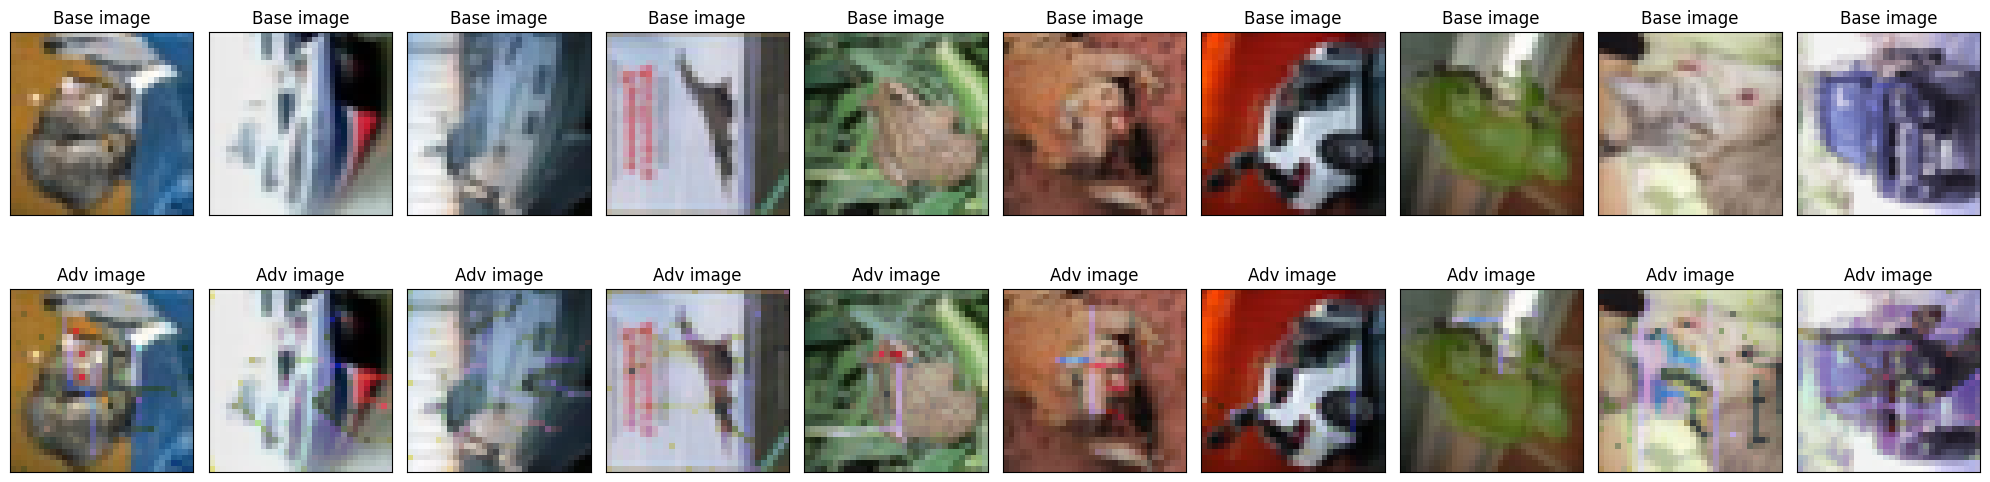

In [ ]:
adv_images = []
y_pred_adv = np.empty(shape=(len(images), len(models)), dtype= 'object')

# Set the attack parameters
eps = 0.4
alpha = 0.1
steps = 200

# Generate adversarial images for each base image using PGD L-Inf attack
for i, image in enumerate(images):
  x = CArray(image)
  y = CArray(images_labels[i])
  adv_images.append(pgd_linf_untargeted(x, y, secml_models, eps, alpha, steps))

  for j, model in enumerate(secml_models):
    y = model.predict(adv_images[i])
    y_pred_adv[i][j] = dataset_labels[y.item()]

# Plot the predicted labels for the adversarial images and display adv images
plot_predicted_labels(model_names, images_labels, y_pred_adv)
display_adv_images(images, adv_images)

# Transferability of PGD L-inf attack
Transferability captures the ability of an attack against a machine-learning model or models to be effective against other different models. For testing the transferability of our PGD L-inf attack which creates ten images able to fool three different machine learning models, I started loading other 7 models from RobustBench which are:
* **Cui2023Decoupled_WRN-28-10**: This model is a WideResNet-28-10. Here I decided to select a model with an equal network archicteture as the *Carmon2019Unlabeled* but a higher robustness against PGD L-inf attacks as reported in RobustBench. The reported robust accuracy is 67.73% compared to the 59.53% of the model *Carmon2019Unlabeled*.
* **Chen2021LTD_WRN34_20**: This model is a WideResNet-34-20. Similarly to the previous case, I decided to select a model with the same network architecture as the one used to perform the PGD attack with a higher robust accuracy. The reported robust accuracy is 57.71% compared to the 53.74% of the model *Pang2020Boosting*.
* **Wang2023Better_WRN-70-16**: This model is a WireResNet-70-16. As in the previous cases, I decided to select a model with the same network architecture of the *Gowal2020Uncovering_70_16* model. However the reported accuracy for this model is 70.69% compared to 57.14% of the model *Gowal2020Uncovering_70_16*.
* **Sehwag2021Proxy_ResNest152**: This model is a ResNest152. ResNest152 is a deep neural network model that is a variant of the ResNet architecture. The reported robust accuracy is 62.79%.
* **Rade2021Helper_R18_extra**: This model is a PreActResNet-18. It is based on the ResNet-18 architecture, which consists of 18 layers in total. The main difference is that in PreActResNet-18, pre-activation blocks are used, where batch normalization and ReLU activation are applied before the convolution operation in each residual block. The reported robust accuracy is 57.67%.
* **Huang2022Revisiting_WRN-A4**: This model is a WideResNet-A4. It is a model proposed by the authors to improve the adversarial robustness of neural networks. The WideResNet-A4 proposed was designed taking into account various scaling factors, such as the depth and width of the network. The reported accuracy is 65.79%.
* **Addepalli2021Towards_RN18**: This model is a ResNet-18. It is a deep convolutional neural network architecture that consists of 18 layers. Each layer is composed of two convolutional layers with batch normalization and ReLU activation functions. A residual connection is added that skips one or more layers and directly connects the input to the output of the block. The reported robust accuracy is 51.06%.

For each model, I printed the prediction over the ten adversarial samples obtained in the previous step. Finally for evaluating the transferability, I started checking the test error with no attacks for each model and I compared it with the resulting test error of target classifiers with attacks. The resulting average transfer rate is finally displayed.


In [ ]:
transferability_models = []
transferability_model_names = ['Cui2023Decoupled_WRN-28-10', 'Chen2021LTD_WRN34_20',
                               'Wang2023Better_WRN-70-16', 'Sehwag2021Proxy_ResNest152',
                               'Rade2021Helper_R18_extra', 'Huang2022Revisiting_WRN-A4',
                               'Addepalli2021Towards_RN18']

# Load the models using the 'load_model' function after loading them from Google Drive
for name in transferability_model_names:
  shutil.copy("/content/drive/MyDrive/" + name + ".pt", "/content/models/cifar10/Linf")
  transferability_models.append(load_model(model_name=name, dataset='cifar10',
                                           threat_model='Linf'))

In [ ]:
secml_transferability_models = []
transferability_models_pred = np.empty(shape=(len(images), len(transferability_models)),
                                       dtype= 'object')

# Convert the PyTorch model to a SECML classifier and append it to the models list
for i, model in enumerate(transferability_models):
  secml_transferability_models.append(CClassifierPyTorch(model, input_shape=(3,32,32),
                                                   pretrained=True))

  # Predict labels for the adversarial images using each transferability model
  for j, img in enumerate(adv_images):
    y = secml_transferability_models[i].predict(img)
    transferability_models_pred[j][i] = dataset_labels[y.item()]

# Plot the predicted labels for the adversarial images using the transferability models
plot_predicted_labels(model_names=transferability_model_names, image_labels=images_labels,
                      y_pred=transferability_models_pred)

,Cui2023Decoupled_WRN-28-10,Chen2021LTD_WRN34_20,Wang2023Better_WRN-70-16,Sehwag2021Proxy_ResNest152,Rade2021Helper_R18_extra,Huang2022Revisiting_WRN-A4,Addepalli2021Towards_RN18
True Label: cat,airplane,cat,airplane,cat,airplane,airplane,cat
True Label: ship,horse,ship,horse,horse,ship,horse,ship
True Label: ship,truck,truck,horse,truck,truck,automobile,automobile
True Label: airplane,ship,ship,horse,ship,ship,deer,ship
True Label: frog,deer,deer,deer,deer,deer,deer,deer
True Label: frog,truck,automobile,truck,truck,truck,truck,automobile
True Label: automobile,cat,cat,cat,cat,cat,cat,cat
True Label: frog,bird,cat,bird,bird,bird,bird,bird
True Label: cat,ship,automobile,horse,horse,automobile,ship,ship
True Label: automobile,airplane,airplane,airplane,airplane,deer,deer,airplane



Testing transferability of Cui2023Decoupled_WRN-28-10:
Test error (no attack): 0.00%

Testing transferability of Chen2021LTD_WRN34_20:
Test error (no attack): 0.00%

Testing transferability of Wang2023Better_WRN-70-16:
Test error (no attack): 0.00%

Testing transferability of Sehwag2021Proxy_ResNest152:
Test error (no attack): 0.00%

Testing transferability of Rade2021Helper_R18_extra:
Test error (no attack): 0.00%

Testing transferability of Huang2022Revisiting_WRN-A4:
Test error (no attack): 0.00%

Testing transferability of Addepalli2021Towards_RN18:
Test error (no attack): 10.00%


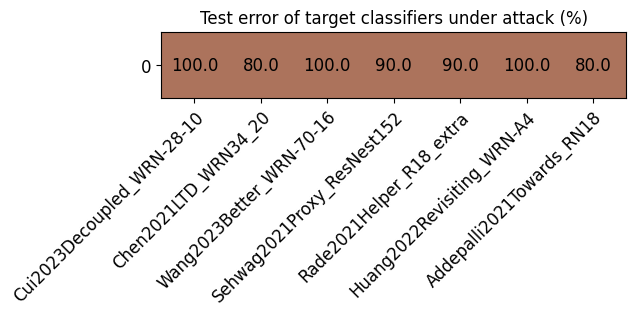


Average transfer rate: 91.43%


In [ ]:
from secml.ml.peval.metrics import CMetricTestError
from secml.array import CArray

# Initialize a test error metric (percentage of wrongly predicted labels)
metric = CMetricTestError()

trans_error = []
transfer_rate = 0.0

# Iterate through each transferability model
for i, target_clf in enumerate(secml_transferability_models):

    print("\nTesting transferability of {0}:".format(transferability_model_names[i]))

    # Calculate the original test error (no attack) for the current model
    images_labels = CArray(images_labels)
    origin_error = metric.performance_score(
            y_true=images_labels, y_pred=target_clf.predict(images))

    print("Test error (no attack): {:.2%}".format(origin_error))

    # Calculate the transfer error under attack for the current model
    trans_error_clf = metric.performance_score(
        y_true=images_labels, y_pred=target_clf.predict(adv_images))

    trans_error.append(trans_error_clf)
    transfer_rate += trans_error_clf

# Compute the average transfer rate across all transferability models
transfer_rate /= len(secml_transferability_models)

# Convert transfer errors to percentage and create a figure to visualize the results
trans_acc = CArray(trans_error) * 100

fig = CFigure(height=1)
a = fig.sp.imshow(trans_acc.reshape((1, 7)),
                  cmap='Oranges', interpolation='nearest',
                  alpha=.65, vmin=60, vmax=70)

fig.sp.xticks(CArray.arange((len(secml_transferability_models))))
fig.sp.xticklabels([name for name in transferability_model_names],
                   rotation=45, ha="right", rotation_mode="anchor")
fig.sp.yticks([0])

for i in range(len(secml_transferability_models)):
    fig.sp.text(i, 0, trans_acc[i].round(2).item(), va='center', ha='center')

fig.sp.title("Test error of target classifiers under attack (%)")

fig.show()

print("\nAverage transfer rate: {:.2%}".format(transfer_rate))